# TC Profiling Paper Plots

Manuel Peuster (manuel.peuster@uni-paderborn.de)

Plots that are used in paper (styling in optimized etc.).

## TODOs

- TODO do column plots with subplots (to save space, no y labels etc!)
- TODO show line style in legends
- TODO add legend background

In [1]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker
sns.set_style("ticks")
sns.set_context({"figure.figsize": (4.5, 3)})

## Load data

Do this only once since our data sources can be multiple GB! Uncompressed files are much faster.

In [2]:
#%time df = pd.read_pickle("data/2018-04-05-experiment_tc_paper_synthetic_all.combined.pkl")
%time df = pd.read_pickle("data/2018-04-06-experiment_tc_paper_synthetic_all.combined.pkl")

CPU times: user 7.29 s, sys: 2.99 s, total: 10.3 s
Wall time: 10.3 s


In [3]:
print("Selectors:")
print(list(set(list(df["selector_conf"]))))
print("\n\nPredictors:")
print(list(set(list(df["predictor_conf"]))))


Selectors:
['WVS_bpm=1-bpmp=False-pspv=8-smmm=2', 'WVS_bpm=2-bpmp=False-pspv=16-smmm=2', 'WVS_bpm=2-bpmp=False-pspv=4-smmm=2', 'WVS_bpm=1-bpmp=False-pspv=16-smmm=2', 'WVS_bpm=0-bpmp=False-pspv=4-smmm=2', 'URS', 'WVS_bpm=0-bpmp=False-pspv=16-smmm=2', 'PGAS_mbp=20', 'WVS_bpm=2-bpmp=False-pspv=8-smmm=2', 'WVS_bpm=0-bpmp=False-pspv=8-smmm=2', 'PGAS_mbp=10', 'WVS_bpm=1-bpmp=False-pspv=4-smmm=2']


Predictors:
['SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2', 'DTRP_a=0.1-dgr=2-e=0.1-mtd=5', 'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2', 'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2', 'RRP_a=0.1-dgr=2-e=0.1-mtd=2', 'LRP_a=0.1-dgr=2-e=0.1-mtd=2']


## Filter data (globally)

In [4]:
# only plot k_samples % 4 == 0 points
df = df[(df["k_samples"] % 4)== 0 ]

## Common Helpers

In [47]:
def _cartesian_product(p_dict):
    """
    Compute Cartesian product on parameter dict:
    In:
        {"number": [1,2,3], "color": ["orange","blue"] }
    Out:
        [ {"number": 1, "color": "orange"},
          {"number": 1, "color": "blue"},
          {"number": 2, "color": "orange"},
          {"number": 2, "color": "blue"},
          {"number": 3, "color": "orange"},
          {"number": 3, "color": "blue"}
        ]
    """
    p_names = sorted(p_dict)
    return [dict(zip(p_names, prod)) for prod in it.product(
        *(p_dict[n] for n in p_names))]

def _generate_filters(df, column_lst):
    """
    config defines arbitrary column names over which we want to iterate
    to create multiple plots, we fetch the possible values of each column
    from the dataset, and compute a float list (cartesian_product) of
    configuration combinations to be plotted
    """
    # extract possible values
    filter_dict = dict()
    for column in column_lst:
        filter_dict[column] = list(set(df[column]))
    # all combinations
    return _cartesian_product(filter_dict)

def _filter_df_by_dict(df, filter_dict):
    """
    do some Pandas magic to dynamically filter df by given dict
    filter_dict = {"column1": "value", "column2": ...}
    """
    return df.loc[
         (df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]

def _get_selector_name(sconf):
    if "WVS_bpm=0" in sconf:
        return "WVS0"
    if "WVS_bpm=1" in sconf:
        return "WVS1"
    if "WVS_bpm=2" in sconf:
        return "WVS2"
    if "PGAS_mbp=10" in sconf:
        return "PGAS10"
    if "PGAS_mbp=20" in sconf:
        return "PGAS20"
    return sconf.split("_")[0]

def _get_predictor_name(pconf):
    return pconf.split("_")[0]

def _get_error_name(err):
    if err == "MSE":
        return "mean squared error (MSE)"
    if err == "R":
        return "coefficient of determination ($R^2$)"
    return err

def _rewrite_legend_texts(leg, rewrite_func):
    for t in leg.texts:
        t.set_text(rewrite_func(t.get_text()))
    

In [44]:
def error_plot(df, filter_dict,
                  title="selector comparison",
                  x="k_samples", y="error_value",
                  hue="selector_conf", # errors are based on this grouping
                  error_bars=95, # ="sd" or =95 (for ci)
                  y_limit=None,
                  x_label="k samples",
                  y_label="error",
                  y_ticks_disabled = False,  # for multi column plots
                  fig_width=6,
                  fig_height=5,
                  legend_loc="upper right",
                  legend_ncol=1,
                  legend_rewrite_func=_get_predictor_name,
                  path=None):
    sns.set_style("ticks", rc={"legend.frameon": False})
    sns.set_context("paper",
                    font_scale=1.6,
                    rc={
                    "lines.linewidth": .7
                    })
    # filters (one filter per plot)
    if isinstance(filter_dict, dict):
        filter_dict_list = [filter_dict]
    else:
        filter_dict_list = filter_dict
    # iterate over all filters to gen. diff. plots
    for f in filter_dict_list:
        # select data to be plotted
        dff = _filter_df_by_dict(df, f)
        if len(dff) < 1:
            print("Filter {} returned 0 data entires.".format(f))
            continue  # nothing to plot
        print("Filtered plot data has {} entries".format(len(dff)))
        fig, ax = plt.subplots(
            figsize=(fig_width,
                     fig_height),
                     dpi=300)
        # do plot
        sns.pointplot(ax=ax,
                      data=dff,
                      x=x,
                      y=y,
                      hue=hue,
                      ci=error_bars,  # ci="sd" or ci=95
                      capsize=.3,
                      markers=["o", "s", "^", "v", "D", "p", "d", "P", "X" "*"],
                      linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":"],
                      #palette="hls",
                      color="dimgray"  # "darkgray"=different grays
                     )

        # custom markers (seaborn does not support it well)
        plt.setp(ax.collections, sizes=[50], facecolor='none')  
        # create legend
        leg = ax.legend(loc=legend_loc, ncol=legend_ncol)
        _rewrite_legend_texts(leg, legend_rewrite_func)
        #fig.suptitle(title)
        ax.set_title(title)
        ax.set_ylabel(y_label)
        # remove y ticks
        if y_ticks_disabled:
            #ax.set_yticks([])
            ax.set_yticklabels([])
        ax.set_xlabel(x_label)
        if y_limit is not None:
            ax.set_ylim(y_limit)
        if path is not None:
            plt.savefig(path, bbox_inches="tight")
        plt.show()

## Predictor Study

Filtered plot data has 86400 entries


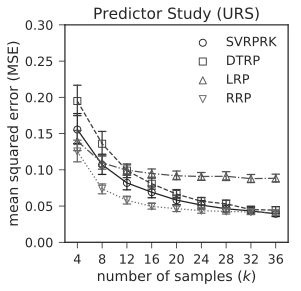

Filtered plot data has 86400 entries


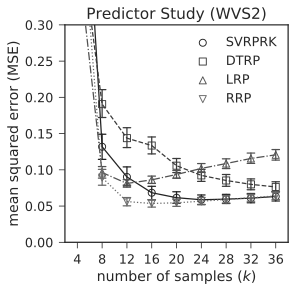

In [63]:
ERRORS = ["MSE"]#, "R"]
SELECTORS = [#'WVS_bpm=2-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=4-smmm=2',
             'URS',
             #'WVS_bpm=0-bpmp=False-pspv=16-smmm=2',
             #'PGAS_mbp=20',
             #'WVS_bpm=1-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=4-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=8-smmm=2',
             #'PGAS_mbp=10',
             'WVS_bpm=2-bpmp=False-pspv=4-smmm=2'
            ]

PREDICTORS = ['DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
              'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2',
              'RRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2'
             ]


# remove poly predictors
dff = df[df["predictor_conf"].isin(PREDICTORS)]

# plot combined topologies
for sel in SELECTORS:
    for err in ERRORS:
        error_plot(
            dff,
            {
             "selector_conf": sel,
             "error": err
            },
            hue="predictor_conf",
            title="Predictor Study ({})".format(_get_selector_name(sel)),
            x_label = "number of samples ($k$)",
            y_label = _get_error_name(err),
            y_limit=[-1.0, 1.0] if err == "R" else [0, .3],
            fig_width=4,
            fig_height=4,
            path="plots/predictor_study_{}_{}.pdf".format(_get_selector_name(sel), err),
        )

## Selector Study

Filtered plot data has 86400 entries


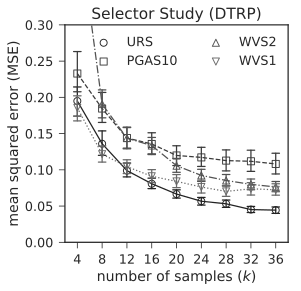

Filtered plot data has 86400 entries


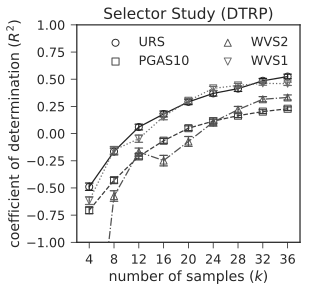

Filtered plot data has 86400 entries


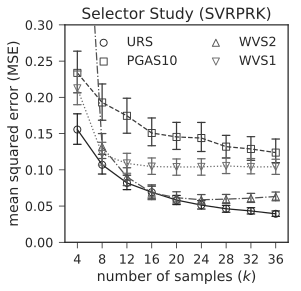

Filtered plot data has 86400 entries


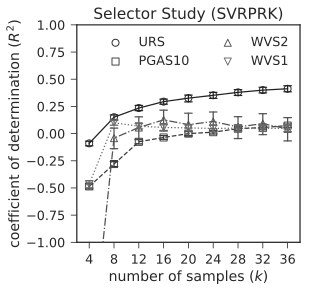

Filtered plot data has 86400 entries


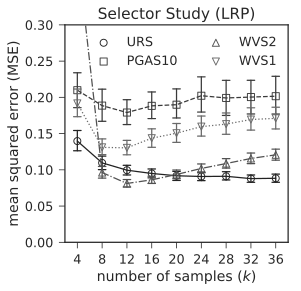

Filtered plot data has 86400 entries


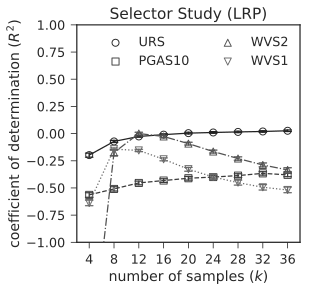

Filtered plot data has 86400 entries


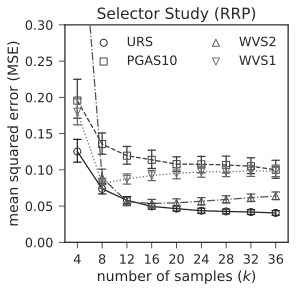

Filtered plot data has 86400 entries


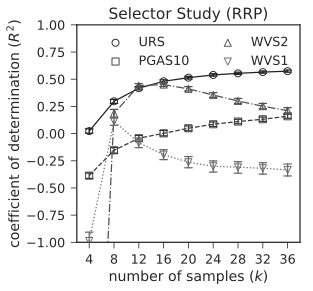

In [62]:
ERRORS = ["MSE", "R"]
SELECTORS = [#'WVS_bpm=2-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=4-smmm=2',
             'URS',
             #'WVS_bpm=0-bpmp=False-pspv=16-smmm=2',
             #'PGAS_mbp=20',
             #'WVS_bpm=1-bpmp=False-pspv=16-smmm=2',
             'WVS_bpm=1-bpmp=False-pspv=4-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=8-smmm=2',
             'PGAS_mbp=10',
             'WVS_bpm=2-bpmp=False-pspv=4-smmm=2'
            ]
PREDICTORS = ['DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
              'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2',
              'RRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2'
             ]

# remove unneeded selectors
dff = df[df["selector_conf"].isin(SELECTORS)]

for pred in PREDICTORS:
    for err in ERRORS:
        error_plot(
                dff, 
                {#"topology": topo,
                 "predictor_conf": pred,
                 "error": err
                },
                title="Selector Study ({})".format(_get_predictor_name(pred)),
                x_label = "number of samples ($k$)",
                y_label = _get_error_name(err),
                y_limit=[-1.0, 1.0] if err == "R" else [0, .3],
                fig_width=4,
                fig_height=4,
                legend_ncol=2,
                legend_rewrite_func=_get_selector_name,
                path="plots/selector_study_{}_{}.pdf".format(_get_predictor_name(pred), err),
            )

## WVS Parameter study

(TODO: it is more or less a 1:1 copy of the selector comparison with other selectors enabled)

## Topology study

* fix predictor
* one plot per topology (have to see what to use in the paper (e.g. d2-5 or l2,d2 and l5,d5)

Filtered plot data has 10800 entries


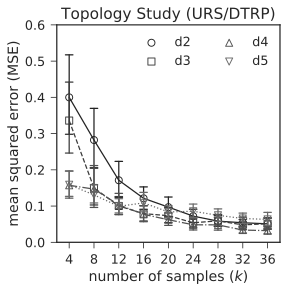

Filtered plot data has 10800 entries


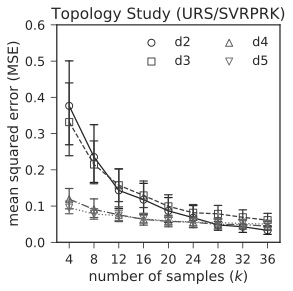

Filtered plot data has 10800 entries


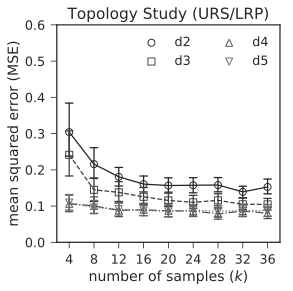

Filtered plot data has 10800 entries


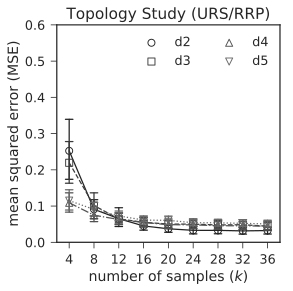

Filtered plot data has 10800 entries


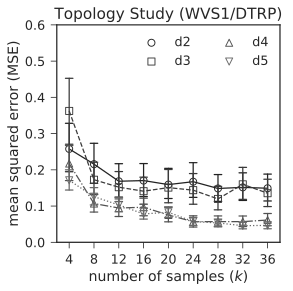

Filtered plot data has 10800 entries


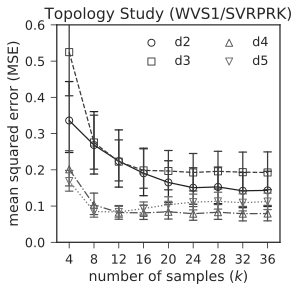

Filtered plot data has 10800 entries


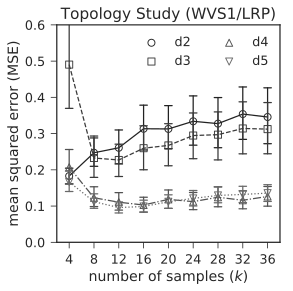

Filtered plot data has 10800 entries


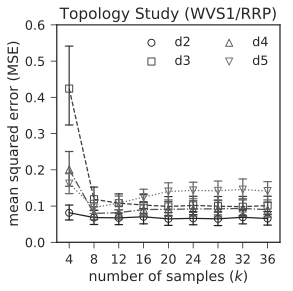

Filtered plot data has 10800 entries


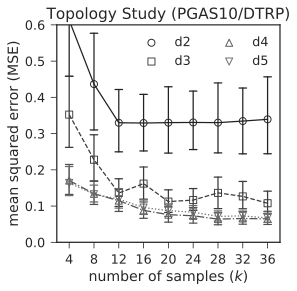

Filtered plot data has 10800 entries


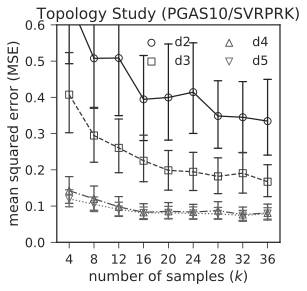

Filtered plot data has 10800 entries


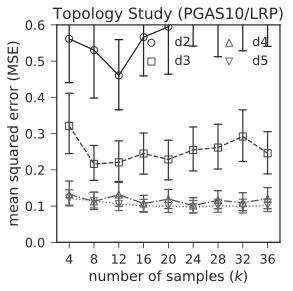

Filtered plot data has 10800 entries


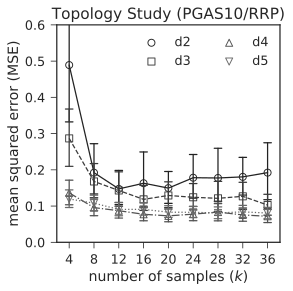

Filtered plot data has 10800 entries


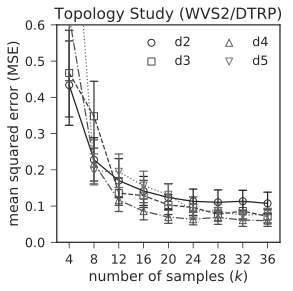

Filtered plot data has 10800 entries


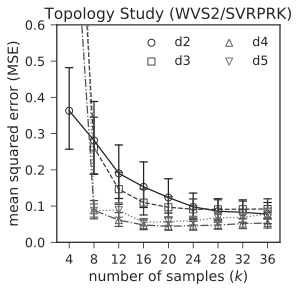

Filtered plot data has 10800 entries


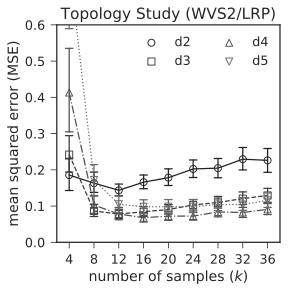

Filtered plot data has 10800 entries


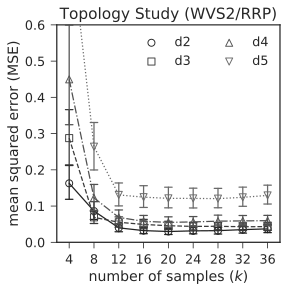

In [61]:
#TOPOLOGIES = ["l2", "l3", "l4", "l5", "d2", "d3", "d4", "d5"]
TOPOLOGIES = ["d2", "d3", "d4", "d5"]
#TOPOLOGIES = ["l2", "l3", "l4", "l5"]

ERRORS = ["MSE"]#, "R"]
SELECTORS = [#'WVS_bpm=2-bpmp=False-pspv=16-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=4-smmm=2',
             'URS',
             #'WVS_bpm=0-bpmp=False-pspv=16-smmm=2',
             #'PGAS_mbp=20',
             #'WVS_bpm=1-bpmp=False-pspv=16-smmm=2',
             'WVS_bpm=1-bpmp=False-pspv=4-smmm=2',
             #'WVS_bpm=2-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=0-bpmp=False-pspv=8-smmm=2',
             #'WVS_bpm=1-bpmp=False-pspv=8-smmm=2',
             'PGAS_mbp=10',
             'WVS_bpm=2-bpmp=False-pspv=4-smmm=2'
            ]
PREDICTORS = ['DTRP_a=0.1-dgr=2-e=0.1-mtd=5',
              'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              'LRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SGDRP_a=0.1-dgr=2-e=0.1-mtd=2',
              'RRP_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2'
             ]

# remove unneeded selectors
dff = df[df["topology"].isin(TOPOLOGIES)]


for sel in SELECTORS:
    for pred in PREDICTORS:
        for err in ERRORS:
            error_plot(
                    dff, 
                    {"selector_conf": sel,
                     "predictor_conf": pred,
                     "error": err
                    },
                    hue="topology",
                    title="Topology Study ({}/{})".format(_get_selector_name(sel), _get_predictor_name(pred)),
                    x_label = "number of samples ($k$)",
                    y_label = _get_error_name(err),
                    y_limit=[-1.0, 1.0] if err == "R" else [0, .6],
                    fig_width=4,
                    fig_height=4,
                    legend_ncol=2,
                    legend_rewrite_func=_get_selector_name,
                    path="plots/topology_study_{}_{}_{}.pdf".format(_get_selector_name(sel), _get_predictor_name(pred), err),
                )